In [3]:
import fastf1 as ff1
from fastf1 import plotting
from fastf1 import utils
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import statsmodels.api as sm
from matplotlib import cm
from matplotlib.collections import LineCollection
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score, f1_score, precision_score, multilabel_confusion_matrix, recall_score
from sklearn.feature_selection import chi2 
import numpy as np
import pandas as pd 
from scipy import stats
import matplotlib.style as stl
from cmath import isnan
import seaborn as sns
stl.use('dark_background')

In [4]:
# this is so that the data can be more quickly accessed later. 
# Replace the file path with yours
ff1.Cache.enable_cache('/Users/javi/Desktop/ff1_cache')

# Introduction

Background:

In 2022, the governing body of Formula One, one of the most prestigious motorsport series, enacted changes that fundamentally shifted the aerodynamic philosophy in cars, bringing back ground effect, a technique for generating downforce, not seen since the 1980s. This was Announced in 2019, following 6 years of dominance by the same manufacturer, Mercedes, and their star Driver, Lewis Hamilton. Additionally, development time restrictions were enacted, so top teams like Mercedes had less wind tunnel time than less successful teams. Fans and officials alike were hopeful for more competitive racing. One of the benefits of ground effect is it directs more air above and behind cars, which makes it easier for other cars to follow and attempt overtakes. The goal of our project is to analyze whether the 2022 regulation changes were successful.

Research question:
1. Did the 2022 regulation changes make racing more competitive?

This question could be approached from multiple angles. For this Phase of the project, I chose to focus on analyzing qualifying and race position for every race of 2021 and 2022, as well as analyzing average position change among the top constructors and midfield cars.

# Preregistration Statement

1. The first analysis I perform is check for competitiveness in F1 by examining the practice session lap data and qualifying time position in a race. This could be achieved with a linear regression, where X includes, for each driver each race weekend, free practice 2 fastest lap, the tyre life on that lap, free practice 3 fastest lap, the tyre life on that lap, a theoretical fastest lap on these two sessions. The, y would be that drivers qualifying time that weekend. This could be performed over multiple seasons as well. The data would be collected from multiple seasons.

2. The second analysis is a tyre analysis, where I attempt to predict the tyre used during a race stint by things like lap time, laps completed, and average speed. This could be done with a logistic regression. Since there are more than two tyre types, it could be a multinomial logistic regression. It would take tyre stints (the set of laps a driver used the same tyres) and attempt to classify them into soft, medium, and hard tyres.

# Data description

I got my data through the API FastF1, which stores all data from F1 race weekends since 2018. This includes all free practice, qualifying, and race data, and has telemetry, lap times, sector times, tyres used, how many laps have been completed on those laps, top speeds, and more. Although I have access to all this data, we had to prepare the data for out analyses in specific ways. FastF1 doesn't let you just access all data at once since the dataset is so large. Instead, you have to pick a race weekend, and you can get more specific, such as choose which session and driver's data you want specifically. Thus, as part of our data preparation, I had to select each driver on each race weekend and extract their data to a central dataframe. Each data analysis section will begin with the code to do this.

# Linear Regression: Analysis # 1

## Data Analysis

In [5]:
def return_round(fp2, fp3, q, track, year):
    df = pd.DataFrame(columns=['year', 'driver', 'team', 'track', 'FP2 fastest lap', 'FP2 tyre life', 'FP3 fastest lap', 'FP3 tyre life', 'theoretical fastest lap', 'qualifying time'])
    drivers = q.drivers
    for driver in drivers:
        try:
            try:
                fp2_driver = fp2.laps.pick_driver(driver).pick_fastest()
            except:
                fp2_driver = fp3.laps.pick_driver(driver).pick_fastest()
            name, team, fp2_fastest_lap, fp2_tyre_life = fp2_driver.Driver, fp2_driver.Team, (fp2_driver.LapTime).total_seconds(), fp2_driver.TyreLife
            try:
                fp3_driver = fp3.laps.pick_driver(driver).pick_fastest()
            except:
                fp3_driver = fp2.laps.pick_driver(driver).pick_fastest()
            fp3_fastest_lap, fp3_tyre_life = (fp3_driver.LapTime).total_seconds(), fp3_driver.TyreLife
            if isnan(fp3_tyre_life) and isnan(fp2_tyre_life):
                fp2_tyre_life = 3.0
                fp3_tyre_life = 3.0
            elif isnan(fp3_tyre_life):
                fp3_tyre_life = fp2_tyre_life
            elif isnan(fp2_tyre_life):
                fp2_tyre_life = fp3_tyre_life
            s1 = fp2_driver.Sector1Time if pd.isnull(fp3_driver.Sector1Time) else fp3_driver.Sector1Time if fp2_driver.Sector1Time else fp2_driver.Sector1Time if fp2_driver.Sector1Time < fp3_driver.Sector1Time else fp3_driver.Sector1Time
            s2 = fp2_driver.Sector2Time if pd.isnull(fp3_driver.Sector2Time) else fp3_driver.Sector2Time if fp2_driver.Sector2Time else fp2_driver.Sector2Time if fp2_driver.Sector2Time < fp3_driver.Sector2Time else fp3_driver.Sector2Time
            s3 = fp2_driver.Sector3Time if pd.isnull(fp3_driver.Sector3Time) else fp3_driver.Sector3Time if fp2_driver.Sector3Time else fp2_driver.Sector3Time if fp2_driver.Sector3Time < fp3_driver.Sector3Time else fp3_driver.Sector3Time
            theoretical = (s1 + s2 + s3).total_seconds()
            if pd.isnull(theoretical):
                theoretical = fp2_fastest_lap if fp2_fastest_lap < fp3_fastest_lap else fp3_fastest_lap
            fastest = (q.laps.pick_driver(driver).pick_fastest().LapTime).total_seconds()
            df = pd.concat([df, pd.DataFrame.from_records([{'year': year, 'driver': name, 'team': team, 'track': track, 'FP2 fastest lap': fp2_fastest_lap, 'FP2 tyre life': fp2_tyre_life, 'FP3 fastest lap': fp3_fastest_lap, 'FP3 tyre life': fp3_tyre_life, 'theoretical fastest lap': theoretical, 'qualifying time': fastest}])])
        except:
            pass
    return df

def return_year(year):
    df = pd.DataFrame(columns=['year', 'driver', 'team', 'track', 'FP2 fastest lap', 'FP2 tyre life', 'FP3 fastest lap', 'FP3 tyre life', 'theoretical fastest lap', 'qualifying time'])
    calendar = ff1.get_event_schedule(year)
    calendar = calendar[calendar['EventFormat'] != 'testing']
    calendar = calendar[['EventFormat', 'EventName', 'Location']]
    if year == 2020:
        calendar = calendar[calendar.EventName != 'Emilia Romagna Grand Prix']
        calendar = calendar[calendar.EventName != 'Styrian Grand Prix']
    if year == 2019:
        calendar = calendar[calendar.EventName != 'Japanese Grand Prix']
    if year == 2021:
        calendar = calendar[calendar.EventName != 'Russian Grand Prix']
    for index, row in calendar.iterrows():
        track = row['EventName']
        session1 = 'FP2'
        session2 = 'FP3'
        if row['EventFormat'] == 'sprint':
            session1 = 'FP1'
            session2 = 'FP2'
        fp2, fp3, q = ff1.get_session(year, track, session1), ff1.get_session(year, track, session2), ff1.get_session(year, track, 'Q')
        fp2.load(telemetry = False, weather = False, messages = False, livedata = False)
        fp3.load(telemetry = False, weather = False, messages = False, livedata = False)
        q.load(telemetry = False, weather = False, messages = False, livedata = False)
        df = pd.concat([df, return_round(fp2, fp3, q, track, year)])
    return df

In [6]:
train = pd.DataFrame(columns=['year', 'driver', 'team', 'track', 'FP2 fastest lap', 'FP2 tyre life', 'FP3 fastest lap', 'FP3 tyre life', 'theoretical fastest lap', 'qualifying time'])
years = [2018, 2019, 2020, 2021]
for year in years:
    train = pd.concat([train, return_year(year)])
test = return_year(2022)

core           INFO 	Loading data for Australian Grand Prix - Practice 2 [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
core        WARNING 	Driver  2: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 35: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 33: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 31: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 28: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 27: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 14: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driv

At this point its worth mentioning why I don't use a train/test split. Although in most cases this makes sense, for me, since we're technically trying to look specifically at 2022 data, it makes sense to train on data from 2018-2021, and test on 2022 data

In [5]:
# When first loading the data, its worth it to store it in a CSV file
# train.to_csv('linear_train.csv')
# test.to_csv('linear_test.csv')

# After the first time, since it takes a long time for the API to load the data, just call the train and test data
# train = pd.read_csv('linear_train.csv')
# test = pd.read_csv('linear_test.csv')

In [7]:
X_train = train.drop(['year', 'driver', 'team', 'track', 'qualifying time'], axis = 1)
y_train = train['qualifying time']
model = LinearRegression().fit(X_train, y_train)

## Evaluation of Significance

In [8]:
print('Training metrics')
print(f'R squared: {model.score(X_train, y_train)}')
print(f'coefficients: {model.coef_}')
print(f'intercept: {model.intercept_}')


Training metrics
R squared: 0.9141879564410055
coefficients: [ 0.23660418  0.06973145  0.01186921 -0.09105798  0.74746169]
intercept: -0.6727987250123988


In [9]:
X_train2 = sm.add_constant(X_train)
X_train2['FP2 fastest lap'] = X_train2['FP2 fastest lap'].astype(float)
X_train2['FP3 fastest lap'] = X_train2['FP3 fastest lap'].astype(float)
X_train2['FP2 tyre life'] = X_train2['FP2 tyre life'].astype(float)
X_train2['FP3 tyre life'] = X_train2['FP3 tyre life'].astype(float)
X_train2['theoretical fastest lap'] = X_train2['theoretical fastest lap'].astype(float)
y_train = y_train.astype(float)
analysis = sm.OLS(y_train, X_train2).fit()
print(analysis.summary())

                            OLS Regression Results                            
Dep. Variable:        qualifying time   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     3109.
Date:                Sat, 11 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:34:58   Log-Likelihood:                -4038.4
No. Observations:                1465   AIC:                             8089.
Df Residuals:                    1459   BIC:                             8121.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [10]:
X_test = test.drop(['year', 'driver', 'team', 'track', 'qualifying time'], axis = 1)
y_test = test['qualifying time']
predicted = model.predict(X_test)
print('Test Metrics')
print(f'R squared: {model.score(X_test, y_test)}')
print(f'MSE: {mean_squared_error(y_test, predicted, squared = True)}')
print(f'RMSE: {mean_squared_error(y_test, predicted, squared = False)}')
print(f'MAE: {mean_absolute_error(y_test, predicted)}')

Test Metrics
R squared: 0.7765089231872959
MSE: 32.834657713221915
RMSE: 5.730153376064371
MAE: 2.79051264712754


Text(0.5, 1.0, 'Actual')

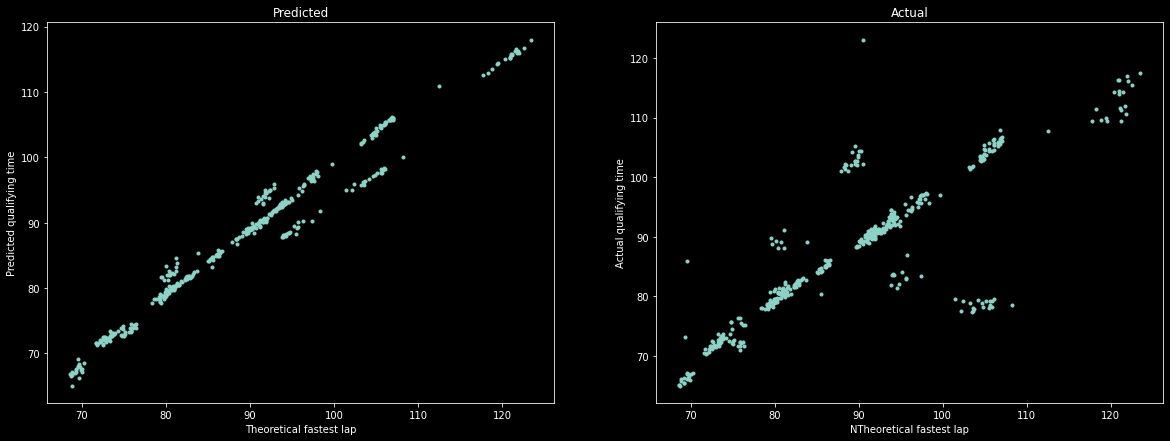

In [11]:
plot1 = pd.DataFrame({'theoretical fastest lap': X_test['theoretical fastest lap'], 'Y_hat': predicted})
plot2 = pd.DataFrame({'theoretical fastest lap': X_test['theoretical fastest lap'], 'Y_hat': y_test})

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,7))
ax1.plot(plot1['theoretical fastest lap'], plot1['Y_hat'], '.')
ax1.set_xlabel("Theoretical fastest lap")
ax1.set_ylabel("Predicted qualifying time")
ax1.set_title("Predicted")

ax2.plot(plot2['theoretical fastest lap'], plot2['Y_hat'], '.')
ax2.set_xlabel("NTheoretical fastest lap")
ax2.set_ylabel("Actual qualifying time")
ax2.set_title("Actual")

## Interpretation and conclusions

Beginning with the training metrics, the R^2 value is 0.914, which is pretty good. R^2 is how well the y fits X, or in this case, how well explained the driver's qualifying time is by their FP2/FP3 fastest lap and tyre life and theoretical fastest lap. Based on the coefficients and intercept, the equation for this regression would be y = 0.23660418 X1 + 0.06973145 X2 + 0.01186921 X3 - 0.09105798 X4 + 0.74746169 X5 - 0.6727987250123988, where X1 = FP2 fastest lap, X2 = FP2 tyre life, X3 = FP3 fastest lap, X4 = FP4 tyre life, and X5 = theoretical fastest lap.

Additionally, I use statsmodel to print the summary of our regression, mostly to look at the p-values. The p values for FP2 fastest lap and FP3 tyre life are particularly interesting, as they are below 0.05, indicating these parameters are statistically significant. Non of the others cross this threshold, however, indicated the model has some predictive power, although this is diluted.

From there, I created predictions based on the test data, and this is where our regression starts to face some challenges. The R^2 value is 0.777, which is considerably lower than the training R^2 value, and indicated that our model does not generalize well, and that parts of the actual qualifying times is unaccounted for by our model. This could be due to a number of reasons, such as other metrics, such as the car's aerodynamic package, driver skill, or perhaps the regulation change. Since the training data is all of the data from 2018-2021, and the testing data is from 2022, it could be that the 2022 regulation change altered the relationship between X and y. Our predictions also have a mean squared error of 32.835, which is pretty bad. Since MSE is sensitive to outliers, this could mean that our model struggle to deal with outliers. In this case, I think outliers are wet weather race weekends. If its raining during a race weekend, certain FP sessions and qualifying times will be slower because the cars are slower in the rain. The root mean squared error is 5.73, which is also not great. The mean absolute error is 2.79, meaning the absolute average error from predicted qualifying time to actual is 2.79 seconds, which is considerable. These metrics suggest that our model does not handle outliers well.

Last, I created a visualization to help show the difference between the predicted qualifying time and actual qualifying time, graphed against the driver's theoretical fastest lap. The figure on the left are the predicted values and the figure on the right are the actual values. As I thought based on our error metrics, wet weather seems to be a point of struggle for our model, but it still does an overall good job of compared to the actual qualifying times. When there is a large difference between theoretical fastest lap and qualifying time, its likely because weather affected either free practice or qualifying.

In relation to our research question, during the process of creating this regression, I realized it was going to be near impossible to create regressions related that directly answer our question. Given our level of experience and the data available, actually answering whether the regulation change narrowed the gap is hard, especially because I don't have access to car-specific data. FastF1 is great, but the actual teams have access to data from thousands of sensors, giving them much more granularity in terms of analyzing competitiveness. Still, you can draw some conclusions from the regression. There is clearly some relationship between free practice data and qualifying time, although this relationship is made more difficult to track due to different weather conditions and driver skill, primarily.

# Multinomial Logistic Regression: Analysis #2

## Data Analysis

In [31]:
def tyre_year(years):
    ret = pd.DataFrame(columns=['LapTime', 'TyreLife', 'Compound', 'Color'])
    for year in years:
        calendar = ff1.get_event_schedule(year)
        calendar = calendar[calendar['EventFormat'] != 'testing']
        calendar = calendar[['EventFormat', 'EventName', 'Location']]
        if year == 2020:
            calendar = calendar[calendar.EventName != 'Emilia Romagna Grand Prix']
            calendar = calendar[calendar.EventName != 'Styrian Grand Prix']
            calendar = calendar[calendar.EventName != 'Eifel Grand Prix']
        if year == 2019:
            calendar = calendar[calendar.EventName != 'Japanese Grand Prix']
        if year == 2021:
            calendar = calendar[calendar.EventName != 'Russian Grand Prix']
            calendar = calendar[calendar.EventName != 'Emilia Romagna Grand Prix']
            calendar = calendar[calendar.EventName != 'Italian Grand Prix']
            calendar = calendar[calendar.EventName != 'British Grand Prix']
            calendar = calendar[calendar.EventName != 'São Paulo Grand Prix']
        if year == 2022:
            calendar = calendar[calendar.EventName != 'São Paulo Grand Prix']
            calendar = calendar[calendar.EventName != 'Emilia Romagna Grand Prix']
            calendar = calendar[calendar.EventName != 'Austrian Grand Prix']
        for index, row in calendar.iterrows():
            track = row['EventName']
            session3 = 'FP3' if row['EventFormat'] == 'conventional' else 'sprint'
            race = ff1.get_session(year, track, 'R')
            fp1 = ff1.get_session(year, track, 'FP1')
            fp2 = ff1.get_session(year, track, 'FP2')
            fp3 = ff1.get_session(year, track, session3)
            race.load(telemetry = False, weather = False, messages = False, livedata = False)
            fp1.load(telemetry = False, weather = False, messages = False, livedata = False)
            fp2.load(telemetry = False, weather = False, messages = False, livedata = False)
            fp3.load(telemetry = False, weather = False, messages = False, livedata = False)
            race_laps = race.laps.pick_drivers(race.drivers).pick_quicklaps()
            for index, row in race_laps.iterrows():
                race_laps.loc[index, 'LapTime'] = race_laps.loc[index, 'LapTime'].total_seconds()
            fp1_laps = fp1.laps.pick_drivers(fp1.drivers).pick_quicklaps()
            for index, row in fp1_laps.iterrows():
                fp1_laps.loc[index, 'LapTime'] = fp1_laps.loc[index, 'LapTime'].total_seconds()
            fp2_laps = fp2.laps.pick_drivers(fp2.drivers).pick_quicklaps()
            for index, row in fp2_laps.iterrows():
                fp2_laps.loc[index, 'LapTime'] = fp2_laps.loc[index, 'LapTime'].total_seconds()
            fp3_laps = fp3.laps.pick_drivers(fp3.drivers).pick_quicklaps()
            for index, row in fp3_laps.iterrows():
                fp3_laps.loc[index, 'LapTime'] = fp3_laps.loc[index, 'LapTime'].total_seconds()
            df = pd.concat([fp1_laps, fp2_laps, fp3_laps, race_laps])
            df = df[['LapTime', 'TyreLife', 'Compound']]
            if 'WET' in df.Compound.unique() or 'INTERMEDIATE' in df.Compound.unique() or 'TEST_UNKNOWN' in df.Compound.unique() or 'UNKNOWN' in df.Compound.unique() or 'TEST' in df.Compound.unique():
                pass
            else:
                df = df.loc[np.logical_not(np.isnan(df['TyreLife']))]
                df["Color"] = np.where(
                    df["Compound"] == "SOFT","Red", np.where(
                        df["Compound"] == "MEDIUM", "Yellow", "White"
                        )
                    )
                ret = pd.concat([df, ret])
    return ret

In [32]:
years = [2019, 2020, 2021]
train = tyre_year(years)
test = tyre_year([2022])

core           INFO 	Loading data for Australian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '33', '5', '16', '20', '27', '7', '18', '26', '10', '4', '11', '23', '99', '63', '88', '8', '3', '55']
core           INFO 	Loading data for Australian Grand Prix - Practice 1 [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track

Similar to the linear regression, since our data is focused on 2022, I chose to make 2022 our test data. For this, only 2019-2021 was used as training data, since the tyre compounds in 2018 were drastically different. Additionally, I removed wet weather race weekends since tyre data for those weekends is very different.

In [13]:
# When first loading the data, its worth it to store it in a CSV file
# train.to_csv('MNLogit_train.csv')
# test.to_csv('MNLogit_test.csv')

# After the first time, since it takes a long time for the API to load the data, just call the train and test data
# train = pd.read_csv('MNLogit_train.csv')
# test = pd.read_csv('MNLogit_test.csv')

In [14]:
y_train = train['Compound']
X_train = train[['LapTime', 'TyreLife']]
X_train['LapTime'] = X_train['LapTime'].astype(float)
X_train['TyreLife'] = X_train['TyreLife'].astype(float)
results = LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, y_train)

/var/folders/0j/1rhcqn_173b1sxlypl_4f72w0000gn/T/ipykernel_8539/466368859.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['LapTime'] = X_train['LapTime'].astype(float)
/var/folders/0j/1rhcqn_173b1sxlypl_4f72w0000gn/T/ipykernel_8539/466368859.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['TyreLife'] = X_train['TyreLife'].astype(float)


## Evaluation of Significance

In [15]:
y_test = test['Compound']
X_test = test[['LapTime', 'TyreLife']]
X_test['LapTime'] = X_test['LapTime'].astype(float)
X_test['TyreLife'] = X_test['TyreLife'].astype(float)
yhat = results.predict(X_test)

/var/folders/0j/1rhcqn_173b1sxlypl_4f72w0000gn/T/ipykernel_8539/153515423.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['LapTime'] = X_test['LapTime'].astype(float)
/var/folders/0j/1rhcqn_173b1sxlypl_4f72w0000gn/T/ipykernel_8539/153515423.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['TyreLife'] = X_test['TyreLife'].astype(float)


Text(0.5, 1.0, 'Actual tyre compound')

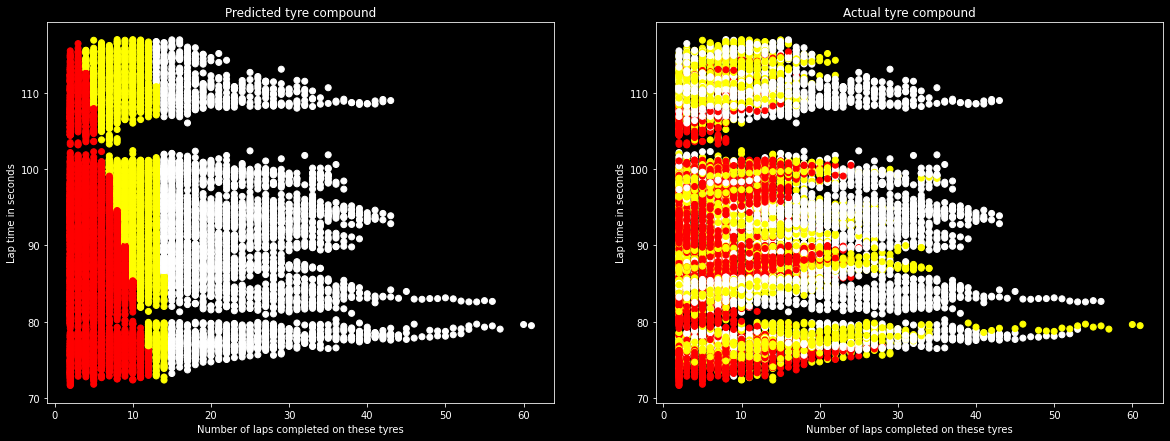

In [16]:
colors = []
for value in yhat:
    if value == 'SOFT':
        color = 'Red'
    elif value =='MEDIUM':
        color = 'Yellow'
    else:
        color = 'White'
    colors.append(color)
test["Actual"] = np.where(
    test["Compound"] == "SOFT", "Red", np.where(
        test["Compound"] == "MEDIUM", "Yellow", 'White'
    )
)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,7))
ax1.scatter(test["TyreLife"], test["LapTime"], c= colors)
ax1.set_xlabel("Number of laps completed on these tyres")
ax1.set_ylabel("Lap time in seconds")
ax1.set_title("Predicted tyre compound")

ax2.scatter(test["TyreLife"], test["LapTime"], c= test['Actual'])
ax2.set_xlabel("Number of laps completed on these tyres")
ax2.set_ylabel("Lap time in seconds")
ax2.set_title("Actual tyre compound")

In [28]:
print(f'accuracy: {accuracy_score(y_test, yhat)}')
print(f'F1: {f1_score(y_test, yhat, average = None)}')
print(f'precision: {precision_score(y_test, yhat, average = None)}')
print(f'recall: {recall_score(y_test, yhat, average = None)}')
print(f'Confusion matrix: \n{multilabel_confusion_matrix(y_test, yhat)}')

accuracy: 0.4676914318246513
F1: [0.52819383 0.3620514  0.50534786]
precision: [0.5691906  0.44503201 0.41226385]
recall: [0.49270598 0.30515267 0.65272497]
Confusion matrix: 
[[[7370 1815]
  [2469 2398]]

 [[6818 1994]
  [3641 1599]]

 [[6436 3671]
  [1370 2575]]]


In [18]:
sm.add_constant(X_train)
logit_model = sm.MNLogit(y_train, X_train).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 1.035831
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:               Compound   No. Observations:                44631
Model:                        MNLogit   Df Residuals:                    44627
Method:                           MLE   Df Model:                            2
Date:                Fri, 09 Dec 2022   Pseudo R-squ.:                 0.05502
Time:                        22:17:49   Log-Likelihood:                -46230.
converged:                       True   LL-Null:                       -48922.
Covariance Type:            nonrobust   LLR p-value:                     0.000
Compound=MEDIUM       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
LapTime             0.0048      0.000     22.195      0.000       0.004       0.005
TyreLife      

## Interpretations and conclusions

Starting with the visualization, its clear theres something very wrong with our regression. The actual tyre used and the one predicted are very different, but the regression make sense considering the input variables. The regression thinks that all tyres with few laps completed are soft compound tyres, and all tyres with a lor of laps completed are hards, and mediums in the middle. This is partly true; soft tyres are designed to provide the most grip, but also lose grip more quickly. The visualization on the right also shows that there is no clear relationship between lap time and tyre life in actuality. Perhaps if the data were prepared differently, another relationship would be clearer.

Moving on to metrics, the accuracy of the regression is 0.468, indicating the model correctly predicted only 46.8% of tyre compounds, which is abysmal. F1 score shows the accuracy for each compound, and the model was best at predicting soft compounds at 0.528, and worst ad hard compounds, predicting 0.503, although all three are predicted at similar rates. Precision score made the most positive predictions for soft tyres, at 0.569, and was worst at hard tyres. For recall, the model was particularly bad with medium compounds, correctly identifying only 0.305 of all tyres that should have been predicted medium. The confusion matrix only further cements this. All of these metrics only confirm what the visualization showed; that the model fails to correctly classify tyre compound.

Last, looking at the stats model summary, the pseudo R^2 of 0.055, and a good R^2 value would be around 0.2 at least, showing again this regression has little classification power. Despite this, the LLR p-value is very low, its likely rounded down to 0.000. Frankly, we're not sure what to make of this, considering how poor of a fit the model is to the data.

In conclusion, this multinomial logistic regression did not do a good job of classifying the tyre compounds correctly. Looking at the actual tyre compounds used, it looks like the actual choice by teams is highly subjective, and perhaps not well captured in general by any model. With more experience, I could make a better model, but for now, this was a good learning experience. Perhaps a better approach to predicting tyre compounds is bayesian, while I took a frequentist approach. So much of compound choice often comes down to human decision making, especially as drivers give feedback on how the car feels during a tyre stint, and this isn't well captured by the data available to us.

# Acknowledgement

The most important thing in helping us complete this project was the FastF1 documentation (https://theoehrly.github.io/Fast-F1/index.html)! There were a lot of error messages along the way, but this helped us a lot. The pandas and sklearn documentations were also useful, as we had to prepare the data using the API with dataframes, and then correctly setting up the regressions. For the interpretations, the class slides were useful to make sure we were interpreting things correctly. The feedback on previous phases was also very helpful.